In [4]:
import networkx as nx
import numpy as np

import matching.glema.common.utils.arg_utils as arg_utils
import matching.glema.common.utils.graph_utils as graph_utils
import matching.glema.common.utils.plot_utils as plot_utils
import matching.glema.common.utils.model_utils as model_utils
import matching.misc.cpg_const as cpg_const
from matching.glema.common.model import InferenceGNN

In [5]:
args = arg_utils.parse_args( use_default=True )

args.dataset = "CPG_augm"
args.directed = False
args.anchored = True
version = model_utils.get_latest_model_version( args )

args = arg_utils.load_args( args, version=version )
args.iso = True
args.test_data = True

In [6]:
model = InferenceGNN( args )

Loading model from /Users/jeanjour/Documents/projects/python/dpd-subgraph-matching/matching/glema/training/save/CPG_augm_undirected_anchored_v1/model.pt ...


In [7]:
def predict( model, G_source, G_query ) -> float:
    results = model.predict_label( [ G_query ], [ G_source ] )
    return results[ 0 ].item()


def is_subgraph( model, G_source, G_query, conf=0.5 ) -> bool:
    prediction = predict( model, G_source, G_query )
    is_sub = prediction > conf
    print( f"query is subgraph of source: {is_sub} [{prediction:.3}]" )
    return is_sub

In [8]:
record_scopes = graph_utils.get_record_scopes( args )
design_patterns = graph_utils.get_design_patterns( args )
label_args = {
    "record_scopes": record_scopes,
    "design_patterns": design_patterns
}

In [9]:
source_graphs = graph_utils.load_source_graphs( args )
pattern_graphs = graph_utils.get_pattern_graphs( args, source_graphs )
{ dp.value: len( l ) for dp, l in pattern_graphs.items() }

{'OBSERVER': 18, 'BUILDER': 12, 'ABSTRACT_FACTORY': 16}

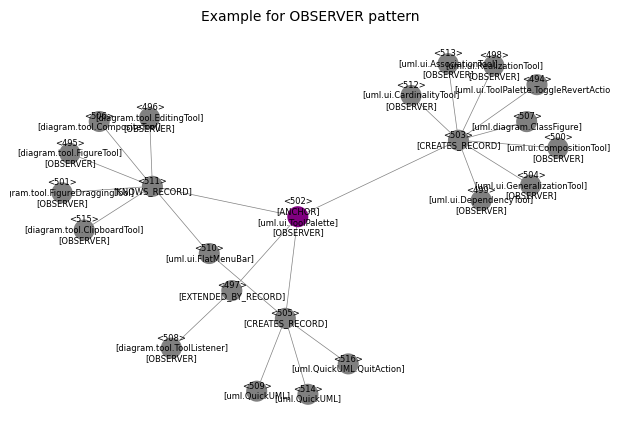

In [10]:
dp_target = cpg_const.DesignPatternType.OBSERVER
dp_target_graph = pattern_graphs[ dp_target ][ 2 ]

plot_utils.plot_graph( dp_target_graph,
                       title=f"Example for {dp_target.value} pattern",
                       nodeColors=graph_utils.get_node_colors( dp_target_graph ),
                       nodeLabels=graph_utils.get_node_labels( dp_target_graph, **label_args ) )

In [11]:
def max_spanning_width( G, start_node ):
    bft_tree = nx.traversal.bfs_tree( nx.Graph( G ), start_node )
    stack = [ (start_node, 0) ]
    max_width = 0
    while stack:
        current_node, depth = stack.pop()
        max_width = max( max_width, depth )
        for child in bft_tree.successors( current_node ):
            stack.append( (child, depth + 1) )
    return max_width


def has_pattern( model, graph, pattern_graphs, pattern_type, conf=0.5 ):
    preds = list()
    pattern_type_queries = pattern_graphs[ pattern_type ]
    for query in pattern_type_queries:
        graph_anchor = graph_utils.get_anchor( graph )
        graph_w = max_spanning_width( graph, graph_anchor )

        query_anchor = graph_utils.get_anchor( query )
        #query_r = max( 1, int( graph_w / 2 ) )
        query_r = graph_w - 1
        query = nx.ego_graph( query, query_anchor, radius=query_r, undirected=True )
        query_w = max_spanning_width( query, query_anchor )
        #query.nodes[ query_anchor ]["anchor"] = 0

        print( f"graph_w: {graph_w} / query_w: {query_w}" )

        matching_colors = {
            2: "purple",
            1: "green",
            0: "grey",
            -1: "red"
        }
        combined, node_colors, edge_colors = graph_utils.combine_graph( graph, query,
                                                                        matching_colors=matching_colors )
        plot_utils.plot_graph(
            title="Combined Graph", graph=combined,
            nodeColors=node_colors, edgeColors=edge_colors,
            nodeLabels=graph_utils.get_node_labels( combined )
        )

        is_subgraph( model, graph, query, conf=conf )
        pred = predict( model, graph, query )
        preds.append( pred )

    preds = np.array( preds )
    mean = np.mean(preds)
    median = np.median(preds)
    var = np.var(preds)
    std = np.std(preds)
    print( f"Total predictions is {mean > conf}: mean[{mean:.3}] median[{median:.3}] var[{var:.3}] std[{std:.3}]" )

graph_w: 4 / query_w: 3


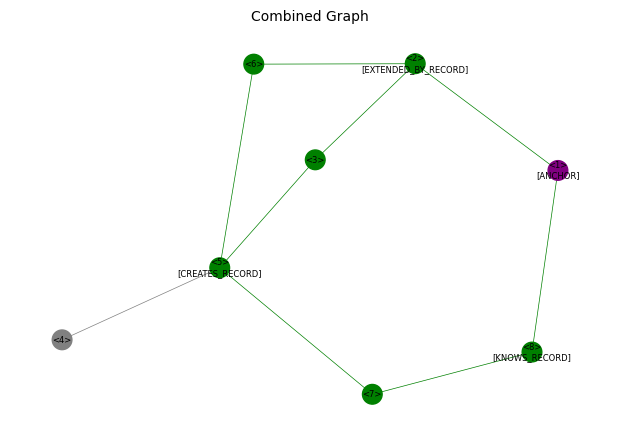

query is subgraph of source: True [0.798]
graph_w: 4 / query_w: 3


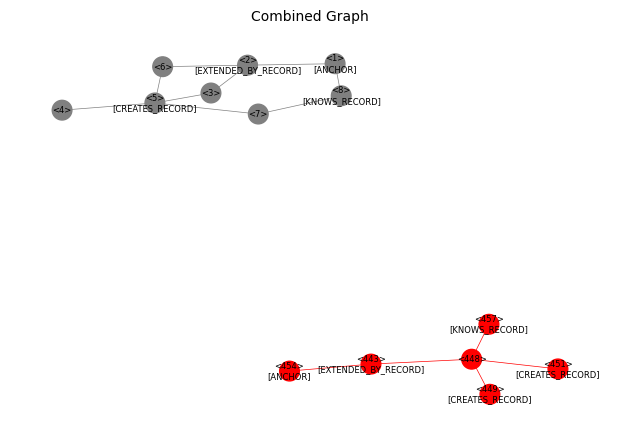

query is subgraph of source: False [0.346]
graph_w: 4 / query_w: 2


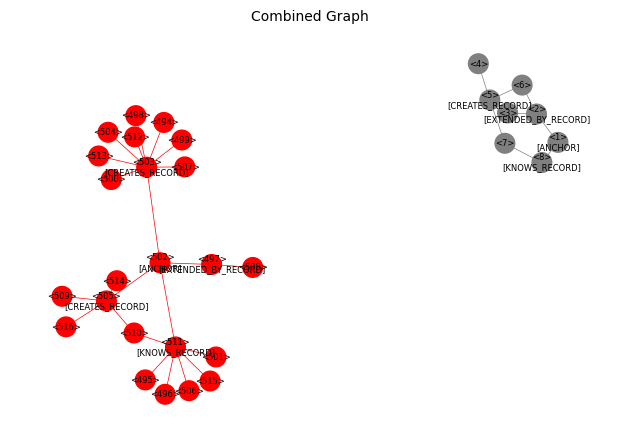

query is subgraph of source: False [0.355]
graph_w: 4 / query_w: 3


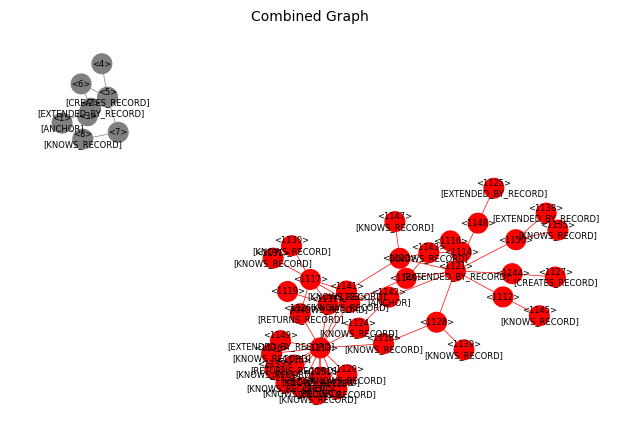

query is subgraph of source: False [0.361]
graph_w: 4 / query_w: 3


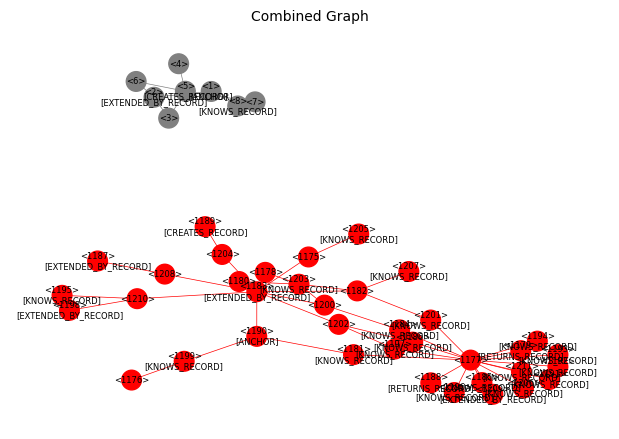

query is subgraph of source: False [0.389]
graph_w: 4 / query_w: 3


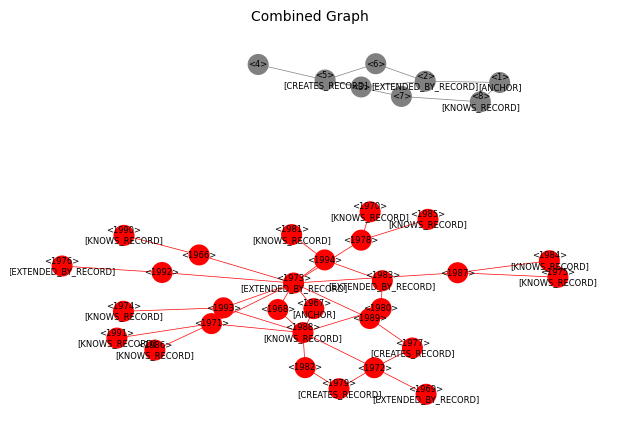

query is subgraph of source: False [0.394]
graph_w: 4 / query_w: 2


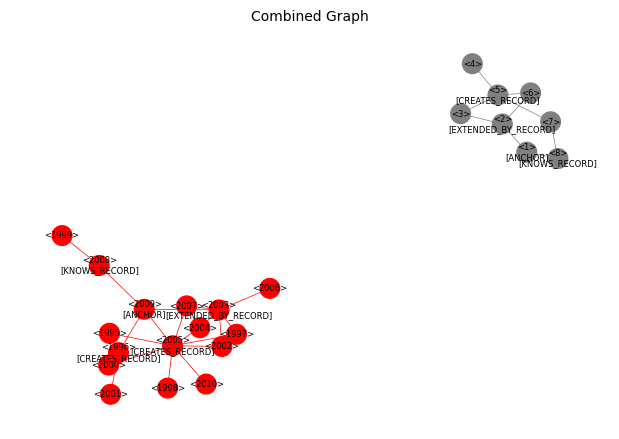

query is subgraph of source: False [0.404]
graph_w: 4 / query_w: 2


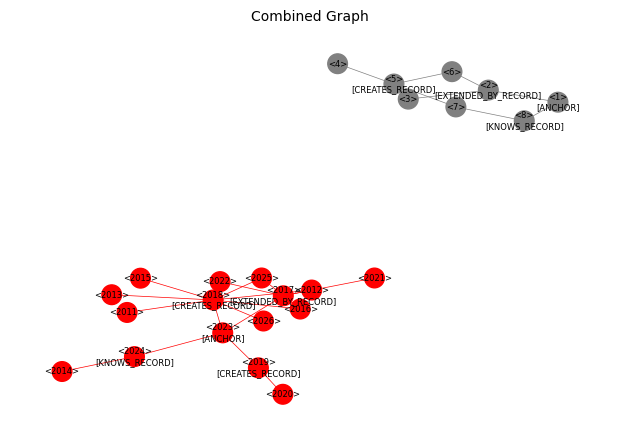

query is subgraph of source: False [0.404]
graph_w: 4 / query_w: 2


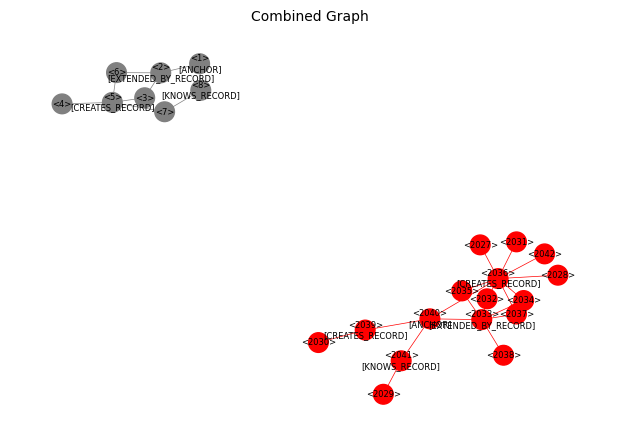

query is subgraph of source: False [0.404]
graph_w: 4 / query_w: 2


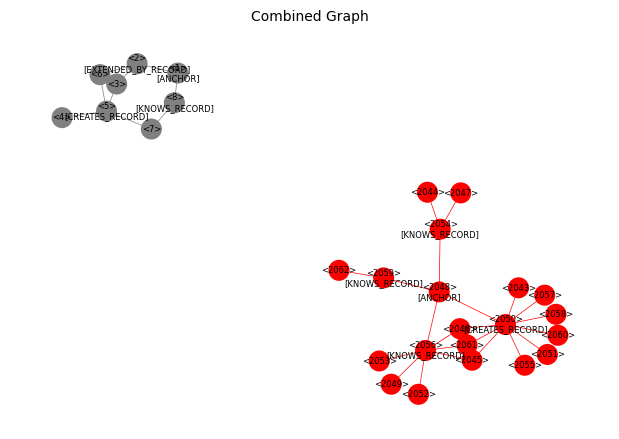

query is subgraph of source: False [0.35]
graph_w: 4 / query_w: 2


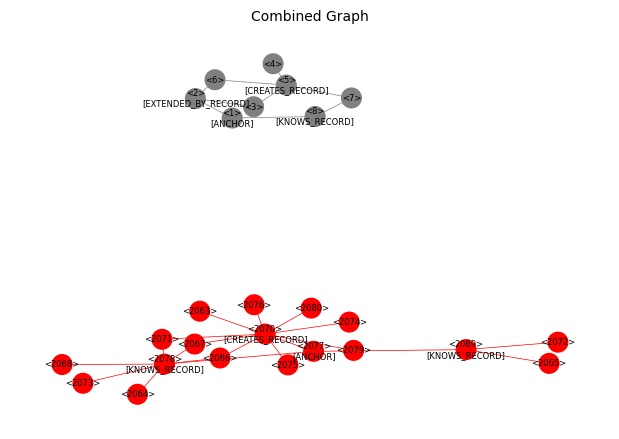

query is subgraph of source: False [0.356]
graph_w: 4 / query_w: 3


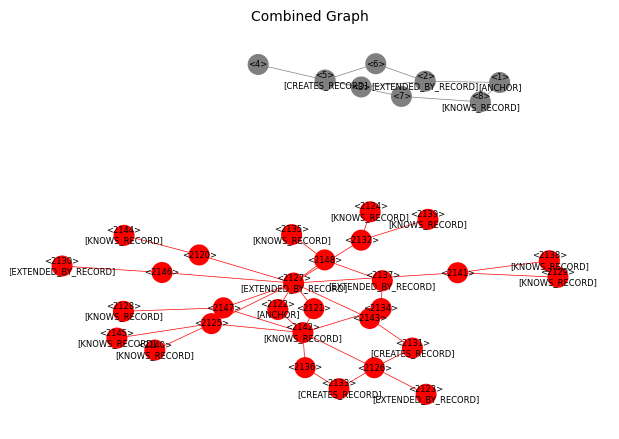

query is subgraph of source: False [0.394]
graph_w: 4 / query_w: 2


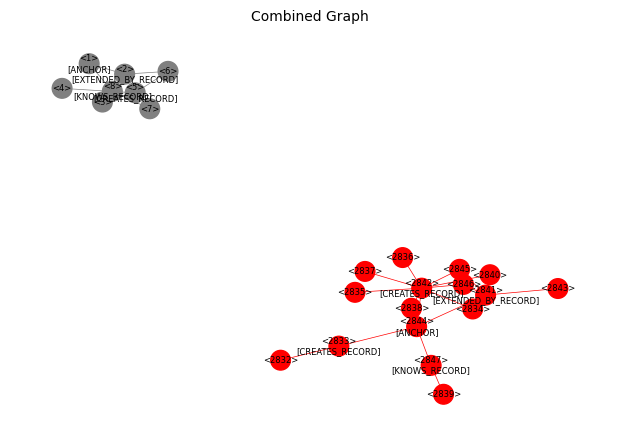

query is subgraph of source: False [0.404]
graph_w: 4 / query_w: 2


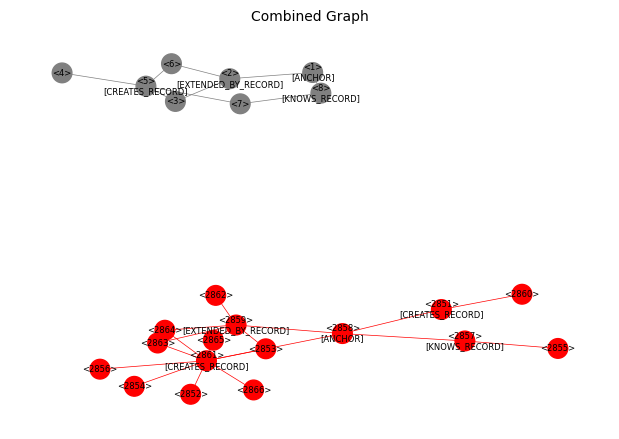

query is subgraph of source: False [0.404]
graph_w: 4 / query_w: 2


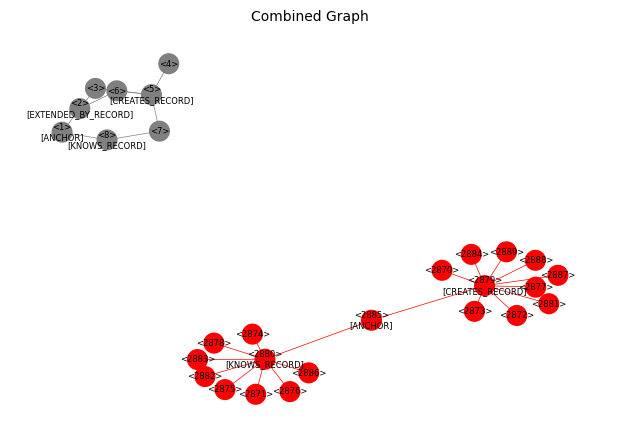

query is subgraph of source: False [0.335]
graph_w: 4 / query_w: 3


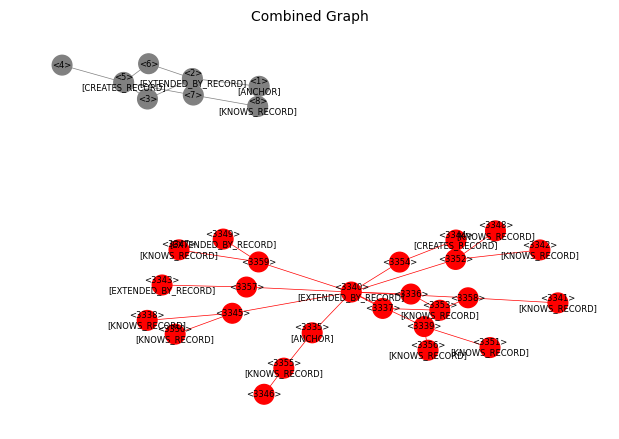

query is subgraph of source: False [0.397]
graph_w: 4 / query_w: 3


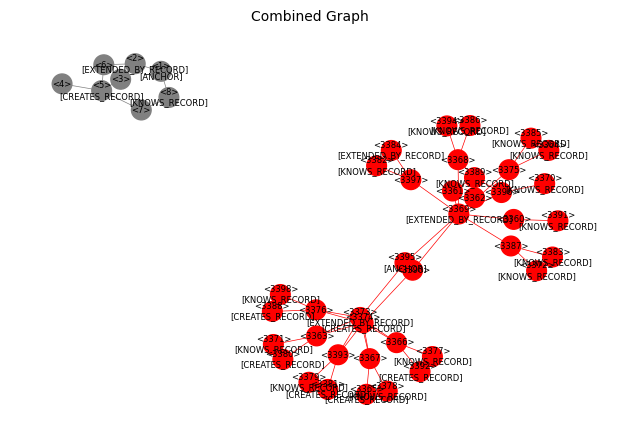

query is subgraph of source: False [0.352]
graph_w: 4 / query_w: 3


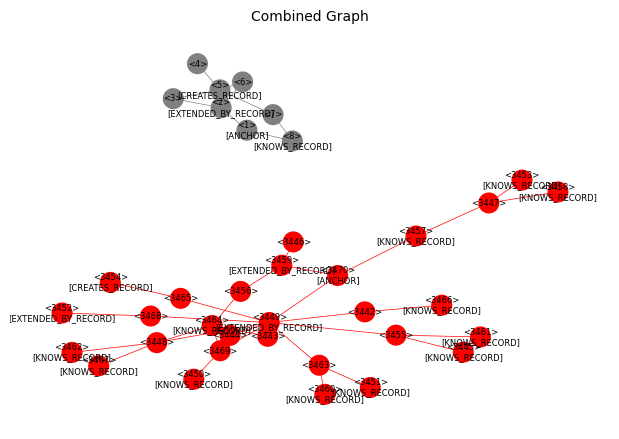

query is subgraph of source: False [0.393]
Total predictions is False: mean[0.402] median[0.394] var[0.00978] std[0.0989]


In [12]:
source_graph = pattern_graphs[ dp_target ][ 0 ]
has_pattern( model, source_graph, pattern_graphs, dp_target, conf=0.5 )

graph_w: 4 / query_w: 3


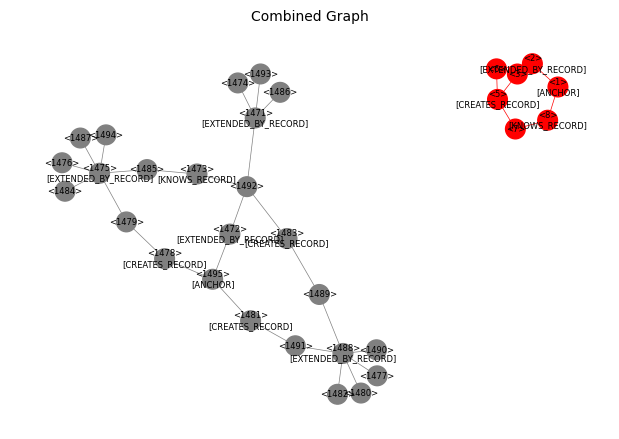

query is subgraph of source: False [0.381]
graph_w: 4 / query_w: 3


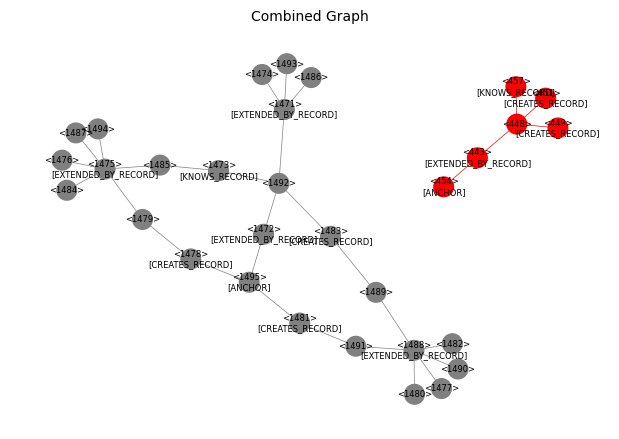

query is subgraph of source: False [0.479]
graph_w: 4 / query_w: 2


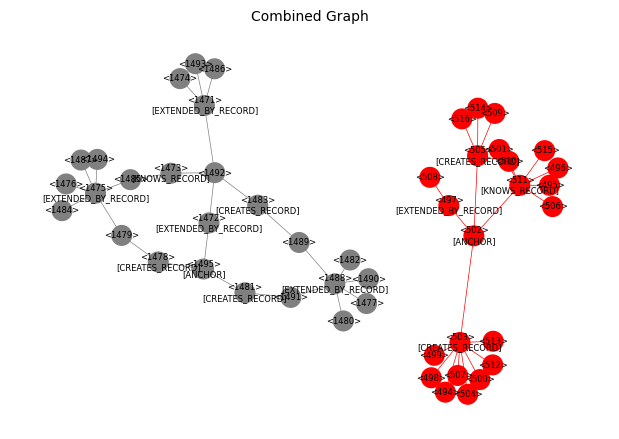

query is subgraph of source: False [0.371]
graph_w: 4 / query_w: 3


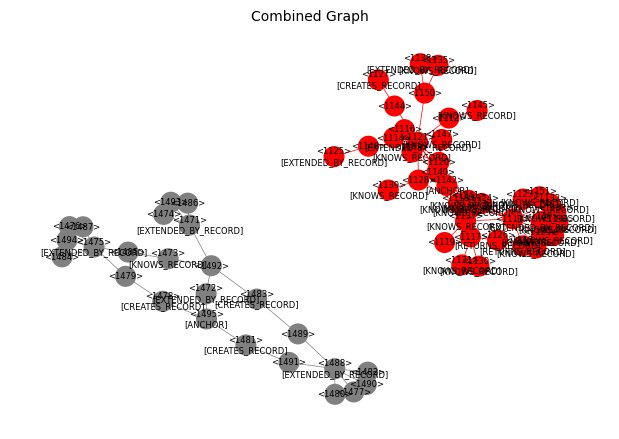

query is subgraph of source: False [0.438]
graph_w: 4 / query_w: 3


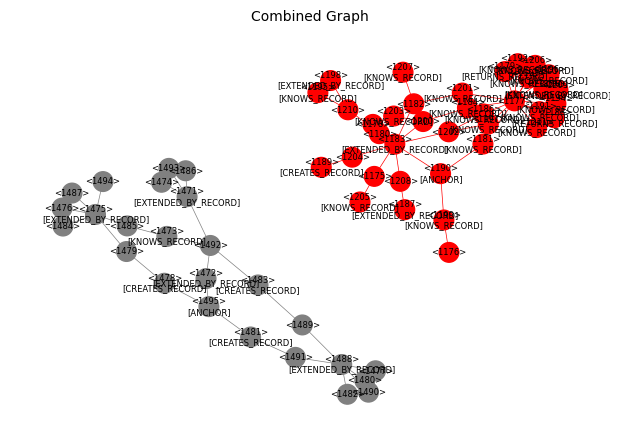

query is subgraph of source: False [0.405]
graph_w: 4 / query_w: 3


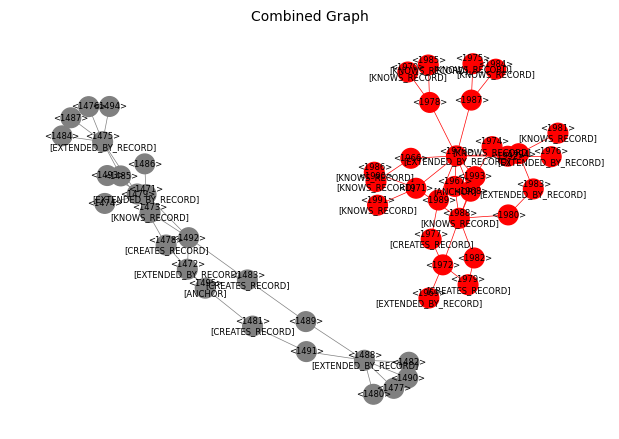

query is subgraph of source: False [0.442]
graph_w: 4 / query_w: 2


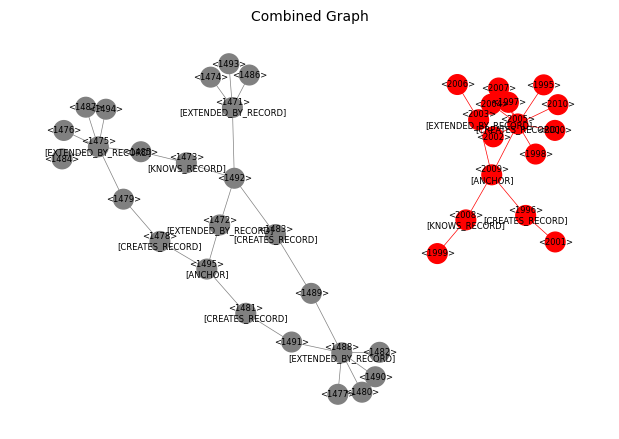

query is subgraph of source: True [0.647]
graph_w: 4 / query_w: 2


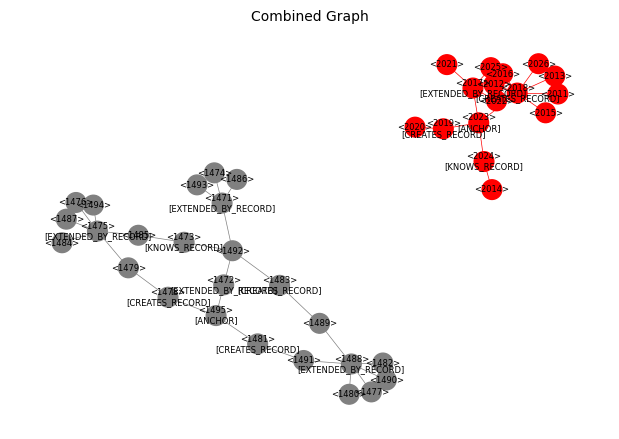

query is subgraph of source: True [0.647]
graph_w: 4 / query_w: 2


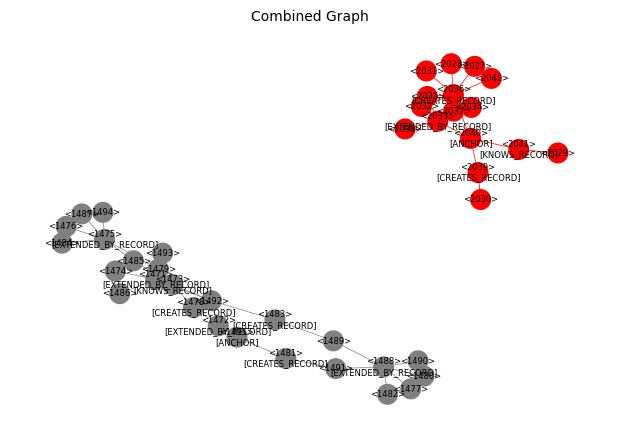

query is subgraph of source: True [0.647]
graph_w: 4 / query_w: 2


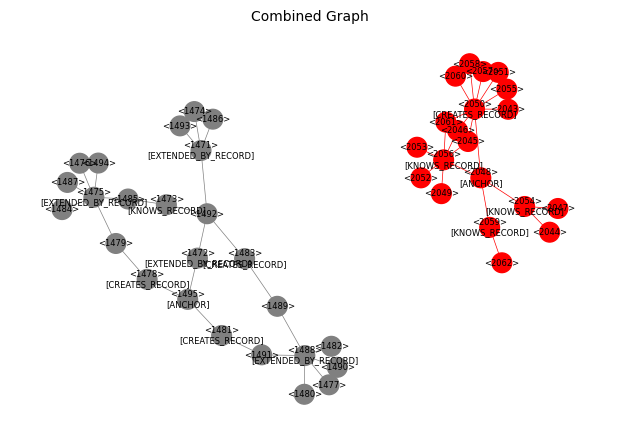

query is subgraph of source: True [0.787]
graph_w: 4 / query_w: 2


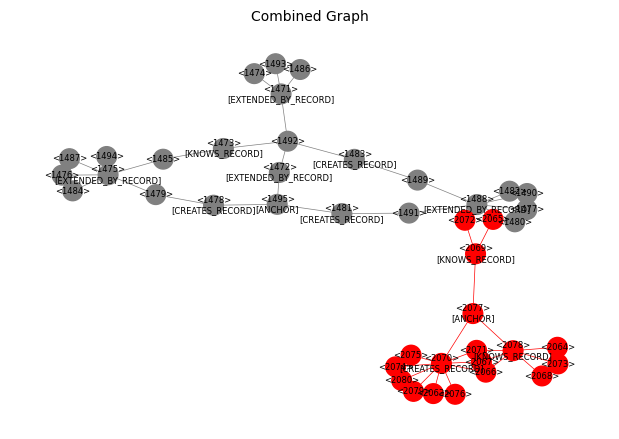

query is subgraph of source: True [0.659]
graph_w: 4 / query_w: 3


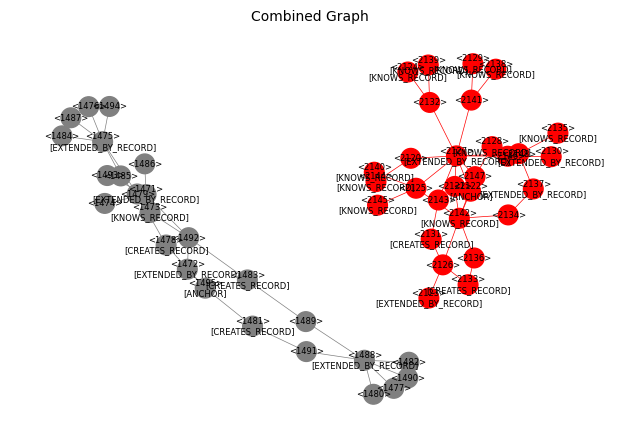

query is subgraph of source: False [0.442]
graph_w: 4 / query_w: 2


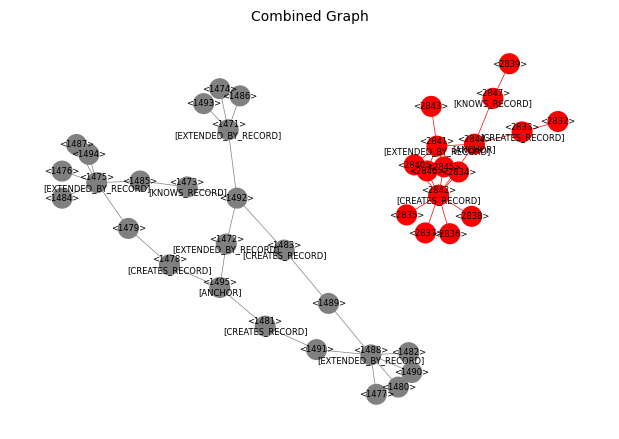

query is subgraph of source: True [0.647]
graph_w: 4 / query_w: 2


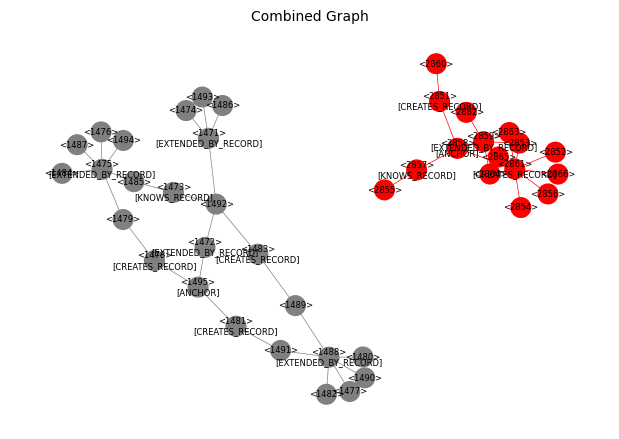

query is subgraph of source: True [0.647]
graph_w: 4 / query_w: 2


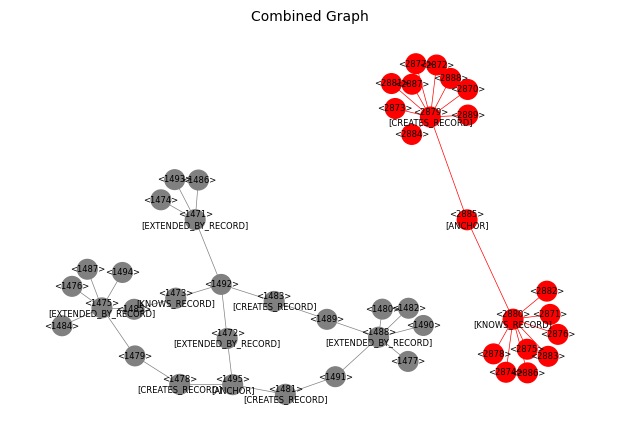

query is subgraph of source: False [0.427]
graph_w: 4 / query_w: 3


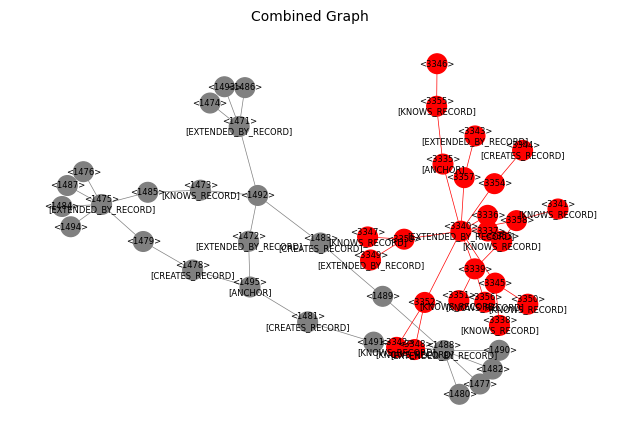

query is subgraph of source: True [0.739]
graph_w: 4 / query_w: 3


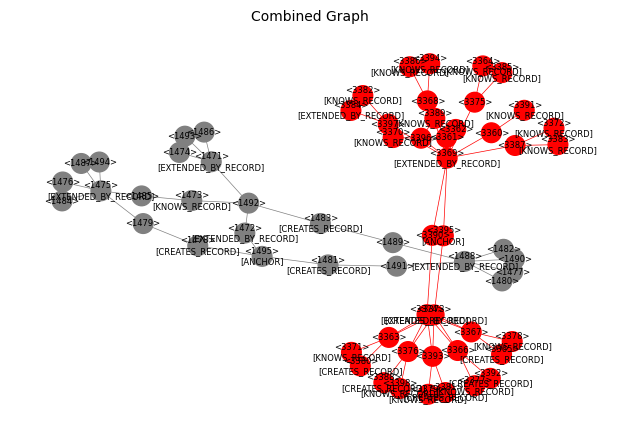

query is subgraph of source: False [0.486]
graph_w: 4 / query_w: 3


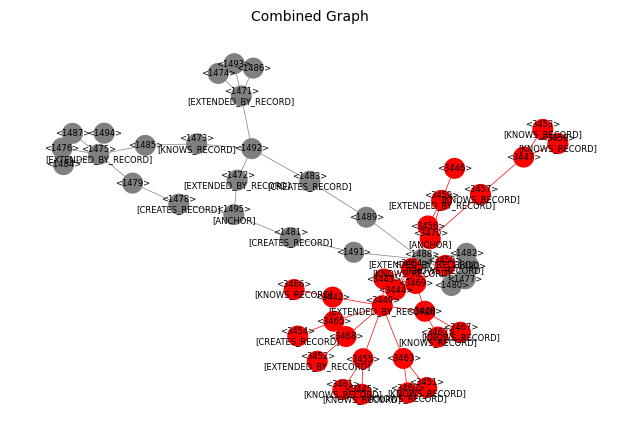

query is subgraph of source: True [0.5]
Total predictions is True: mean[0.544] median[0.493] var[0.0163] std[0.128]


In [13]:
source_graph = pattern_graphs[ cpg_const.DesignPatternType.ABSTRACT_FACTORY ][ 0 ]
has_pattern( model, source_graph, pattern_graphs, dp_target, conf=0.5 )